<a href="https://colab.research.google.com/github/mdparvex/DLD/blob/main/CSE465project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout,BatchNormalization 
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import pandas as pd
#import splitfolders
import os
import cv2
import numpy as np
import random

In [11]:
labels = ['glioma', 'meningioma', 'pituitary']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [12]:
train = get_data('/content/drive/MyDrive/Colab Notebooks/splited_Brain_Tumor/train')
val = get_data('/content/drive/MyDrive/Colab Notebooks/splited_Brain_Tumor/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


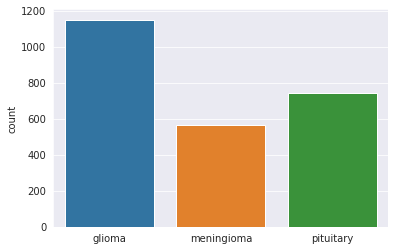

In [13]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("glioma")
    elif(i[1]==1):
        l.append('meningioma')
    else:
        l.append("pituitary")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'glioma')

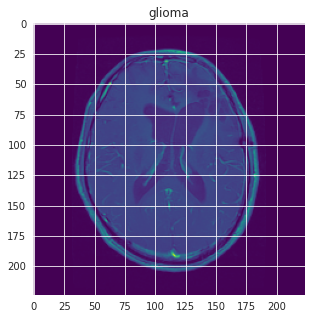

In [14]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'pituitary')

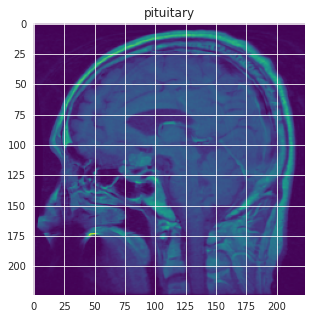

In [15]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [16]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [17]:
x_train.shape

(2459, 224, 224, 3)

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [19]:
model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, 3, padding="same", activation="relu"))
#model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(3, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

In [20]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) , metrics = ['accuracy'])

In [21]:
history = model.fit(x_train,y_train,epochs = 20,batch_size=128 , validation_data = (x_val, y_val))

Epoch 1/20
20/20 [==============================] - 370s 18s/step - loss: 0.7779 - accuracy: 0.6413 - val_loss: 1.0529 - val_accuracy: 0.4608
Epoch 2/20
20/20 [==============================] - 389s 19s/step - loss: 0.5268 - accuracy: 0.7584 - val_loss: 1.0386 - val_accuracy: 0.7778
Epoch 3/20
20/20 [==============================] - 380s 19s/step - loss: 0.4610 - accuracy: 0.7995 - val_loss: 0.9830 - val_accuracy: 0.7255
Epoch 4/20
20/20 [==============================] - 384s 19s/step - loss: 0.3752 - accuracy: 0.8406 - val_loss: 0.9506 - val_accuracy: 0.8725
Epoch 5/20
20/20 [==============================] - 394s 20s/step - loss: 0.3274 - accuracy: 0.8654 - val_loss: 0.9169 - val_accuracy: 0.7647
Epoch 6/20
20/20 [==============================] - 384s 19s/step - loss: 0.2605 - accuracy: 0.9032 - val_loss: 0.8538 - val_accuracy: 0.8922
Epoch 7/20
20/20 [==============================] - 400s 20s/step - loss: 0.2192 - accuracy: 0.9187 - val_loss: 0.7799 - val_accuracy: 0.8333
Epoch 

In [22]:
model.save('model.h5')

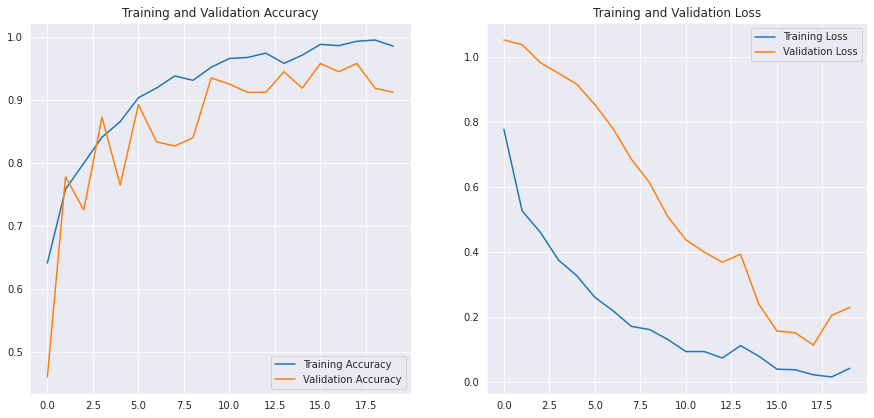

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
model=tf.keras.models.load_model('model.h5')

In [25]:
prediction=model.predict([x_val])

In [26]:
print(np.argmax(prediction[160]))

1


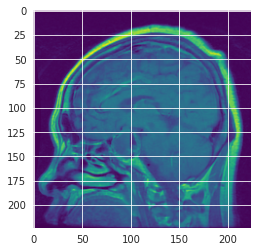

In [27]:
plt.imshow(x_val[304])
plt.show()

In [29]:
test_data_dir= '/content/drive/MyDrive/Colab Notebooks/splited_Brain_Tumor/test'
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir
                                                           , target_size=(224, 224)
                                                           , batch_size=5
                                                           , classes=labels
                                                           , seed=0
                                                           , shuffle=False)

Found 310 images belonging to 3 classes.


In [30]:
train_data_dir='/content/drive/MyDrive/Colab Notebooks/splited_Brain_Tumor/train'
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir
                                                           , target_size=(224, 224)
                                                           , batch_size=10
                                                           , classes=labels
                                                           , seed=0
                                                           , shuffle=True)

Found 2459 images belonging to 3 classes.


In [31]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [32]:
predictions = probability_model.predict(test_generator)

In [33]:
predictions[39]

array([0.21194157, 0.5761169 , 0.21194157], dtype=float32)

In [43]:
np.argmax(predictions[160])

2

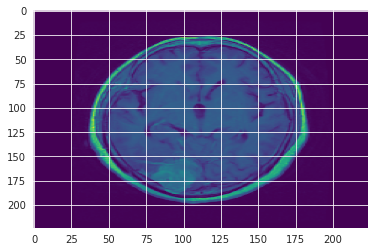

predicted: $pituitary Mis-classified


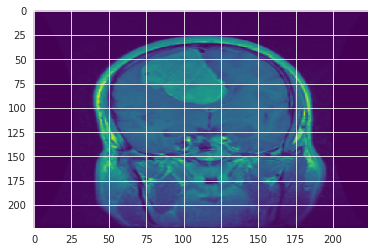

predicted: $meningioma Correctly Classified


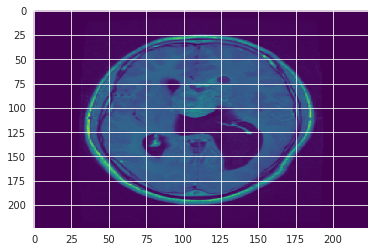

predicted: $pituitary Mis-classified


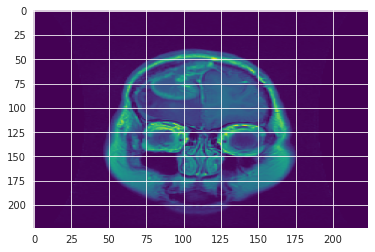

predicted: $meningioma Mis-classified


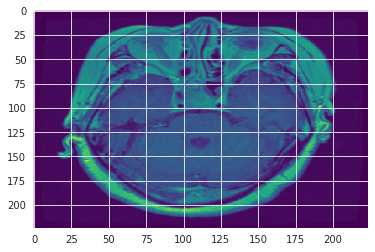

predicted: $pituitary Correctly Classified


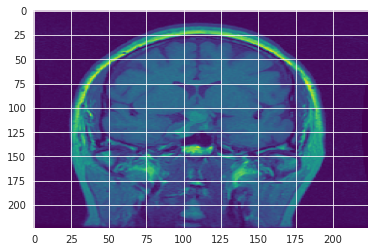

predicted: $pituitary Correctly Classified


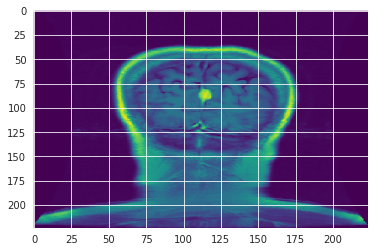

predicted: $meningioma Correctly Classified


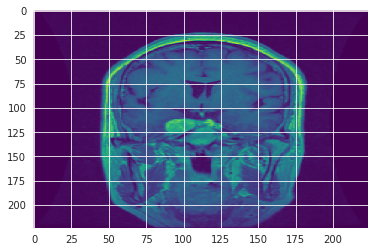

predicted: $meningioma Correctly Classified


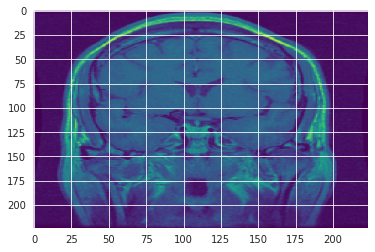

predicted: $pituitary Correctly Classified


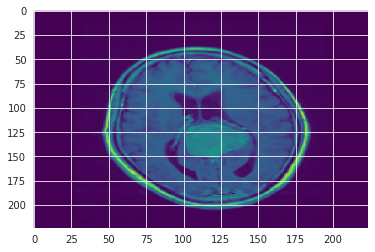

predicted: $meningioma Correctly Classified


In [42]:
# Plot five random images and their predictions
random.seed(0)
numbers = [random.randint(0, 309) for i in range(0, 10)]

actual = test_generator.classes 

predict = np.argmax(model.predict(test_generator),axis =1)


for num in numbers:
   
    for key, value in train_generator.class_indices.items():
        if value == predict[num]:
            key_value = key
    
    plt.imshow(test_generator[num // 5][0][num % 5].astype(np.uint8), aspect='auto')
    plt.show()
    
    if predict[num] == actual[num] :
        print ('predicted: ${} Correctly Classified' .format(key_value))

    else:
        print ('predicted: ${} Mis-classified'.format(key_value))